In [9]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# 폰트 설치
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc

!apt-get -qq -y install fonts-nanum > /dev/null

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 12, 'font.family': 'NanumGothic'}) # 폰트 설정
plt.rcParams['axes.unicode_minus'] = False


In [ ]:
pip install konlpy

In [ ]:
from collections import Counter
import konlpy
from konlpy.tag import Hannanum, Okt
import re

raw_df = pd.read_csv('./content/lyrics_by_year.csv', encoding='utf-8') # 연도별 멜론 순위권 노래 가사 데이터 불러오기
df = raw_df.sort_values(by=['year', 'id']).reset_index(drop=True)  # year과 id 기준으로 정렬
lyrics_all_df = df.copy()   # 작업용 Dataframe 생성
unique_songs_all = lyrics_all_df.drop_duplicates(subset=['id'])   # id를 기준으로 중복 제거

h = Hannanum()    # 형태소 분석을 위해 Hannaum 클래스 초기화
okt = Okt()       # 형태소 분석을 위해 okt 클래스 초기화

def get_nouns(text):        # 명사 추출 함수
    return h.nouns(text)

def get_okt(text):          # okt 형태소 분석기 사용
    # 줄바꿈을 공백으로 변환,  형태소 정규화 및 원형화
    return okt.pos(text.replace('\n', ' '), norm=True, stem=True)

def filter_unicode(text, unicode_range):  # 텍스트 필터링
    start, end = unicode_range
    return ''.join(filter(lambda c: start <= c <= end, text))

def to_single_space(text):                # 공백이 두 개 이상일 경우 한 개로 바꿈
    return re.sub('\s{2,}', ' ', text).strip()

def filter_language(text, lang='kr'):
    if lang == 'kr':
        return re.sub(r'[^\uac00-\ud7a3\s]+', '', text)  # 한글 필터
    elif lang == 'en':
        return re.sub(r'[^a-zA-Z\s]+', '', text)  # 영어 필터
    return re.sub(r'[^\s]+', '', text)  # 기타 문자 필터

counter_kr = Counter()
lyrics = unique_songs_all['lyric']

for lyric in lyrics:
    l_ko = filter_language(str(lyric), 'kr')  # 한국어만 추출
    sentence = [f"{word}_{ty}_kr" for word, ty in get_okt(l_ko)]  # 형태소 분석 (단어별로 분리)
    c = Counter(sentence)
    counter_kr += c         # 단어 빈도 정보 저장
    del c


In [ ]:
import nltk                                             # 자연어 처리 라이브러리
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize                 # 비슷한 프로젝트들의 표제어 추출 로직 참조

nltk.download('popular')                                # 자연어 처리

lemmatizer = WordNetLemmatizer()                        # 표제어 추출
stemmer = PorterStemmer()                               # 어간 추출

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [ ]:
def complete_word(words):       # 축약형 단어 처리
    def complete(word):
        if word == 'I': return ['I']
        if word == 'Im': return ['I', 'am']
        if word == 'Ill': return ['I', 'will']
        return [word.lower()]
    r = []
    for w in words:
        r += complete(w)
    return r

counter_en = Counter()

for l in lyrics:
    l = '' if type(l) != str else l     # 가사가 문자열이 아닌 경우
    sentence = filter_language(l, 'en') # 영어 가사만 필터링
    if len(sentence) < 1:               # 가사가 비어있을 경우
        continue
    words = complete_word(sentence.split()) # 단어 확장 및 처
    c = Counter([f"{lemmatizer.lemmatize(word, 'v')}_Eng_en" for word in words])  # 표제어 처리
    counter_en += c                     # 단어 빈도 정보 저장
    del c

count_pairs = []
counter = counter_kr + counter_en   # 한국어와 영어 단어 빈도 정보 합산

for key, count in counter.items():
    word, kind, lang = key.split('_')               # 단어, 품사, 언어 분리
    count_pairs.append((word, kind, count, lang))   # 튜플로 저장

count_df = pd.DataFrame(count_pairs, columns=['word', 'type', 'count', 'language'])
count_df = count_df.sort_values(by=['count', 'type'], ascending=[False, True])  # 빈도 기준 내림차순, 품사 기준 오름차순

# 결과 저장
count_df.to_csv('lyrics_words_count.csv', encoding='utf-8', index=False)

In [ ]:
import numpy as np

def get_words_counts(df) -> dict:
    d = df[['word', 'count']]       # 단어와 빈도만 포함된 DataFrame
    d.index = d['word']             # 단어를 인덱스로 설정
    d = d.drop(['word'], axis=1)    # 단어 컬럼 제거
    return d.to_dict()['count']     # 딕셔너리 형식으로 반환

count_df['type'].unique()
is_kr = count_df['language'] == 'kr'      # 한국어
is_en = count_df['language'] == 'en'      # 영어
is_noun = count_df['type'] == 'Noun'      # 명사
is_verb = count_df['type'] == 'Verb'      # 동사
is_adj = count_df['type'] == 'Adjective'  # 형용사

rows = []
years = sorted(lyrics_all_df.year.unique())

for year in years:
    df = lyrics_all_df[lyrics_all_df.year == year].copy()   # 가사의 연도별로 고유 값 추출, 오름차순 정렬
    kr_wc, en_wc, etc = [], [], []          # 한국어 단어, 영어 단어, 기타
    kr_wc_r, en_wc_r, etc_r = [], [], []    # 전체 단어 수에 대한 비율
    for l in df['lyric']:
        l = l if type(l) is str else ''
        l = l.replace('\n', ' ').strip()
        k = len(filter_language(l, 'kr').split())   # 한국어 필터링
        e = len(filter_language(l, 'en').split())   # 영어 필터링
        z = len(l.replace(' ', '')) - k - e         # 기타
        total = k + e + z
        kr_wc.append(k)
        kr_wc_r.append(k / total if total > 0 else 0)   # 비율 계산
        en_wc.append(e)
        en_wc_r.append(e / total if total > 0 else 0)   # 비율 계산
        etc.append(z)
        etc_r.append(z / total if total > 0 else 0)     # 비율 계산

    rows.append([
        sum(kr_wc), sum(en_wc), sum(etc),                   # 단어 총합
        np.mean(kr_wc_r), np.mean(en_wc_r), np.mean(etc_r)  # 비율 평균
    ])

rows = np.array(rows)

cnt_df = pd.DataFrame(rows, columns=[
    'kr_words', 'en_words', 'etc_words',                    # 한국어 단어, 영어 단어, 기타
    'kr_words_ratio', 'en_words_ratio', 'etc_words_ratio'   # 전체 단어 수의 대한 비율
])
cnt_df['year'] = years
for col in ['kr_words', 'en_words', 'etc_words']:
    cnt_df[col] = cnt_df[col].astype(int)
cnt_df = cnt_df[[                                           # 연도별
    'year',
    'kr_words', 'en_words', 'etc_words',
    'kr_words_ratio', 'en_words_ratio', 'etc_words_ratio'
]]

ratio_df = cnt_df[['year']].copy()
ratio_df['kr_en'] = cnt_df['kr_words_ratio'] / (cnt_df['kr_words_ratio'] + cnt_df['en_words_ratio'])  # 한국어 비율 계산
ratio_df['en_kr'] = cnt_df['en_words_ratio'] / (cnt_df['kr_words_ratio'] + cnt_df['en_words_ratio'])  # 영어 비율 계산

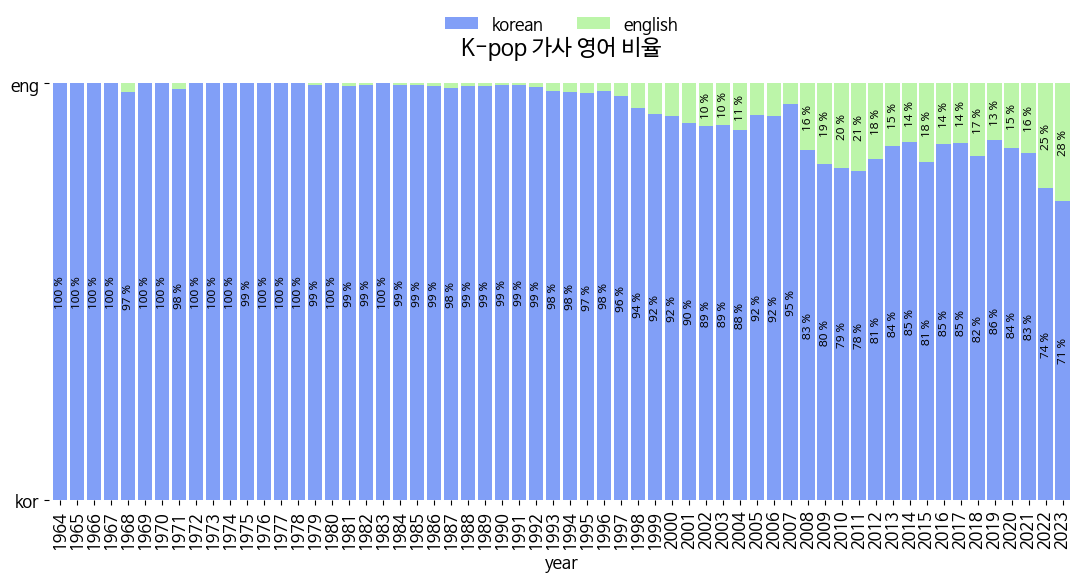

Graph saved to ./result/kpop_english_ratio.png


In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# 결과 저장 경로
output_dir = "./result"
output_path = os.path.join(output_dir, "kpop_english_ratio.png")

# 디렉토리 생성
os.makedirs(output_dir, exist_ok=True)

# 시각화
fig, ax = plt.subplots(1, 1, figsize=[11, 6])
x_var, y_var = "kr_en", "en_kr"
df_grouped = ratio_df[[x_var, y_var]]
df_grouped.columns = ['korean', 'english']
df_grouped.plot.bar(stacked=True, width=0.85, ax=ax, color=['#819FF7', '#BCF5A9'])
plt.xticks(ticks=range(len(df_grouped)), labels=ratio_df['year'])
plt.yticks(ticks=[0, 1], labels=['kor', 'eng'])
plt.legend(
    bbox_to_anchor=(0.5, 1.05),
    loc="lower center",
    borderaxespad=0,
    frameon=False,
    ncol=2
)
for ix, row in df_grouped.reset_index(drop=True).iterrows():
    cumulative = 0
    for element in row:
        if element == element and element > 0.1:
            plt.text(
                ix,
                cumulative + element / 2,
                f"{int(element * 100)} %",
                va="center",
                ha="center",
                rotation=90,
                color="black",
                fontsize="x-small",
            )
        cumulative += element
plt.xlabel('year')
plt.title('K-pop 가사 영어 비율', fontsize=16, color='black')
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)
plt.tight_layout()

# 결과 저장
plt.savefig(output_path, bbox_inches='tight')
plt.show()

print(f"시대별 k-pop 가사 분석 시각화가 저장되었습니다. : {output_path}")


In [ ]:
import os
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 연도별 가장 많이 사용된 단어 계산 및 저장
years = sorted(unique_songs_all.year.unique())
top_words_per_year_kr = {}
top_words_per_year_en = {}

for year in years:
    df_year = unique_songs_all[unique_songs_all.year == year]

    # 한국어 단어 처리
    kr_words = Counter()
    for lyric in df_year['lyric']:
        lyric = str(lyric).replace('\n', ' ').strip() if isinstance(lyric, str) else ''
        kr_words.update(filter_language(lyric, 'kr').split())

    # 영어 단어 처리
    en_words = Counter()
    for lyric in df_year['lyric']:
        lyric = str(lyric).replace('\n', ' ').strip() if isinstance(lyric, str) else ''
        en_words.update(filter_language(lyric, 'en').split())

    # 상위 10개 단어 추출
    top_words_per_year_kr[year] = kr_words.most_common(10)
    top_words_per_year_en[year] = en_words.most_common(10)

# 연도 선택 위젯 생성
year_widget = widgets.Dropdown(
    options=years,
    description='연도 선택:',
    disabled=False
)

# 선택된 연도에 따라 시각화
def update_graph(year):
    # 한국어 단어 시각화
    top_kr_words = pd.DataFrame(top_words_per_year_kr[year], columns=['word', 'count'])
    fig, axs = plt.subplots(1, 1, figsize=(12, 6))
    sns.barplot(data=top_kr_words, x='count', y='word', ax=axs, palette='Blues_r')
    axs.set_title(f"{year}년 한국어 단어 순위")
    axs.set_xlabel("횟수")
    axs.set_ylabel("단어")
    axs.tick_params(axis="y", labelsize=8)
    plt.tight_layout()
    kr_path = os.path.join(output_dir, f"Korean_Words_Ranking{year}.png")
    plt.savefig(kr_path)
    plt.show()

    print(f"한국어 단어 순위 시각화가 저장되었습니다. : {kr_path}")

    # 영어 단어 시각화
    if len(top_words_per_year_en[year]) > 0:  # 영어 단어가 존재하는지 확인
        top_en_words = pd.DataFrame(top_words_per_year_en[year], columns=['word', 'count'])
        fig, axs = plt.subplots(1, 1, figsize=(12, 6))
        sns.barplot(data=top_en_words, x='count', y='word', ax=axs, palette='Oranges_r')
        axs.set_title(f"{year}년 영어 단어 순위")
        axs.set_xlabel("횟수")
        axs.set_ylabel("단어")
        axs.tick_params(axis="y", labelsize=8)
        plt.tight_layout()
        en_path = os.path.join(output_dir, f"English_Words_Ranking_{year}.png")
        plt.savefig(en_path)
        plt.show()

        print(f"영어 단어 순위 시각화가 저장되었습니다. : {en_path}")
    else:
        print(f"{year}년에 사용된 영어 단어가 없습니다. 시각화를 하지 않습니다.")

# 위젯과 함수를 연결하여 화면에 표시
widgets.interactive(update_graph, year=year_widget)


interactive(children=(Dropdown(description='연도 선택:', options=(1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, …

시각화가 './result/nobody_lyrics_english_ratio.png'에 저장되었습니다.


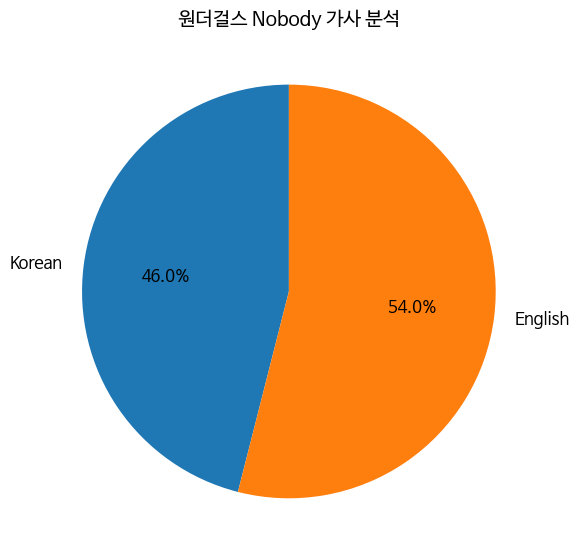

In [ ]:
# 2009년 빌보드 Hot100 최초 진입 k-pop
# 원더걸스 - Nobody

filename = "./content/Nobody_lylics.txt"

save_file = os.path.join(output_dir, "nobody_lyrics_english_ratio.png")

try:
    with open(filename, "r", encoding="utf-8") as file:
        lyrics = file.read()
except FileNotFoundError:
    print(f"파일 '{filename}'을 찾을 수 없습니다.")
    raise

# 한국어, 영어 필터링 함수
def filter_language(text, lang='kr'):
    if lang == 'kr':
        return re.sub('[^\uac00-\ud7a3\s]+', '', text)  # 한글만 남기기
    elif lang == 'en':
        return re.sub('[^a-zA-Z\s]+', '', text)  # 영어만 남기기
    return ""

# 한국어와 영어 단어 추출 및 비율 계산
kr_words = filter_language(lyrics, lang='kr').split()
en_words = filter_language(lyrics, lang='en').split()

kr_count = len(kr_words)
en_count = len(en_words)
total_count = kr_count + en_count

kr_ratio = kr_count / total_count if total_count > 0 else 0
en_ratio = en_count / total_count if total_count > 0 else 0

# 시각화 및 저장
fig, ax = plt.subplots(figsize=(6, 6))
labels = ['Korean', 'English']
ratios = [kr_ratio, en_ratio]
colors = ['#1f77b4', '#ff7f0e']

ax.pie(
    ratios,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12}
)

ax.set_title("원더걸스 Nobody 가사 분석", fontsize=14)
plt.tight_layout()

# 시각화 저장
plt.savefig(save_file)
print(f"시각화가 '{save_file}'에 저장되었습니다.")

# 그래프 표시
plt.show()

시각화가 './result/gangnamStyle_lyrics_english_ratio.png'에 저장되었습니다.


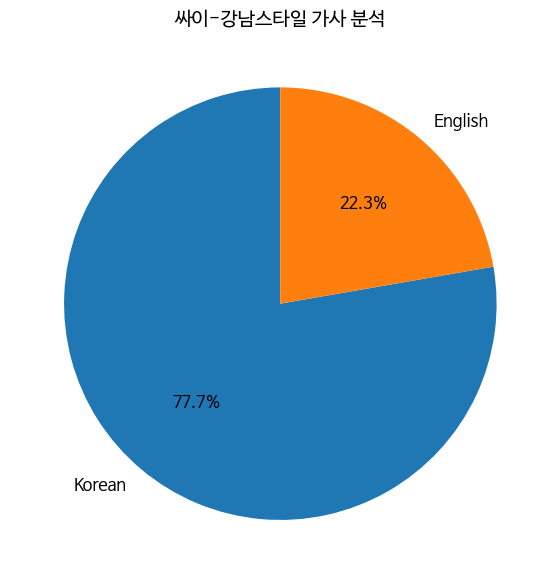

In [14]:
# 2012년 빌보드 Hot100 2위
# 싸이 - 강남스타일

filename = "./content/강남스타일_lylics.txt"

save_file = os.path.join(output_dir, "gangnamStyle_lyrics_english_ratio.png")

try:
    with open(filename, "r", encoding="utf-8") as file:
        lyrics = file.read()
except FileNotFoundError:
    print(f"파일 '{filename}'을 찾을 수 없습니다.")
    raise

# 한국어, 영어 필터링 함수
def filter_language(text, lang='kr'):
    if lang == 'kr':
        return re.sub('[^\uac00-\ud7a3\s]+', '', text)  # 한글만 남기기
    elif lang == 'en':
        return re.sub('[^a-zA-Z\s]+', '', text)  # 영어만 남기기
    return ""

# 한국어와 영어 단어 추출 및 비율 계산
kr_words = filter_language(lyrics, lang='kr').split()
en_words = filter_language(lyrics, lang='en').split()

kr_count = len(kr_words)
en_count = len(en_words)
total_count = kr_count + en_count

kr_ratio = kr_count / total_count if total_count > 0 else 0
en_ratio = en_count / total_count if total_count > 0 else 0

# 시각화 및 저장
fig, ax = plt.subplots(figsize=(6, 6))
labels = ['Korean', 'English']
ratios = [kr_ratio, en_ratio]
colors = ['#1f77b4', '#ff7f0e']

ax.pie(
    ratios,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12}
)

ax.set_title("싸이-강남스타일 가사 분석", fontsize=14)
plt.tight_layout()

# 시각화 저장
plt.savefig(save_file)
print(f"시각화가 '{save_file}'에 저장되었습니다.")

# 그래프 표시
plt.show()

시각화가 './result/dynamite_lyrics_english_ratio.png'에 저장되었습니다.


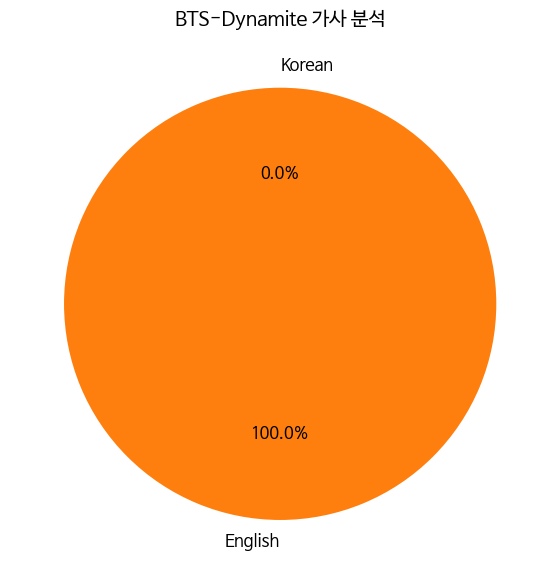

In [13]:
# 2020년 빌보드 Hot100 k-pop 첫 1위
# BTS - Dynamite

filename = "./content/Dynamite_lylics.txt"

save_file = os.path.join(output_dir, "dynamite_lyrics_english_ratio.png")

try:
    with open(filename, "r", encoding="utf-8") as file:
        lyrics = file.read()
except FileNotFoundError:
    print(f"파일 '{filename}'을 찾을 수 없습니다.")
    raise

# 한국어, 영어 필터링 함수
def filter_language(text, lang='kr'):
    if lang == 'kr':
        return re.sub('[^\uac00-\ud7a3\s]+', '', text)  # 한글만 남기기
    elif lang == 'en':
        return re.sub('[^a-zA-Z\s]+', '', text)  # 영어만 남기기
    return ""

# 한국어와 영어 단어 추출 및 비율 계산
kr_words = filter_language(lyrics, lang='kr').split()
en_words = filter_language(lyrics, lang='en').split()

kr_count = len(kr_words)
en_count = len(en_words)
total_count = kr_count + en_count

kr_ratio = kr_count / total_count if total_count > 0 else 0
en_ratio = en_count / total_count if total_count > 0 else 0

# 시각화 및 저장
fig, ax = plt.subplots(figsize=(6, 6))
labels = ['Korean', 'English']
ratios = [kr_ratio, en_ratio]
colors = ['#1f77b4', '#ff7f0e']

ax.pie(
    ratios,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12}
)

ax.set_title("BTS-Dynamite 가사 분석", fontsize=14)
plt.tight_layout()

# 시각화 저장
plt.savefig(save_file)
print(f"시각화가 '{save_file}'에 저장되었습니다.")

# 그래프 표시
plt.show()